# Data Preparation

## Install necessary packages

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn import model_selection
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import re

## Data Cleaning & Feature Engineering

In [ ]:
data = pd.read_csv('/content/ML Dataset BRI.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   name                                       112 non-null    object 
 1   countries                                  112 non-null    object 
 2   regions                                    112 non-null    object 
 3   status                                     112 non-null    object 
 4   finance                                    90 non-null     object 
 5   ownership                                  107 non-null    object 
 6   total_cost (USD)                           107 non-null    float64
 7   capacity(MW)                               111 non-null    float64
 8   fuel_type                                  112 non-null    object 
 9   Agriculture in GDP                         112 non-null    float64
 10  Gas Rents (% of GDP)      

In [ ]:
data.shape

(112, 26)

In [ ]:
data

,name,countries,regions,status,finance,ownership,total_cost (USD),capacity(MW),fuel_type,Agriculture in GDP,...,External debt/GDP ratio,Imports of Goods and Services as % of GDP,Exports of Goods and Services (% of GDP),Democracy Score,Landlocked,Borders Russia,Borders China,Economic Complexity,Population Density /km2,status_label
0,Jumar HPS,Tajikistan',"Russia, Central Asia and the South Caucasus'",Delayed,NaN,NaN,3.769000e+09,2000.0,Hydro',0.24,...,0.41,0.38,0.17,0.02,Y,N,Y,94,72,0
1,Dushanbe-2 Power Plant Expansion,Tajikistan',"Russia, Central Asia and the South Caucasus'",Completed,BRI,SJSC,3.490000e+08,300.0,Coal',0.24,...,0.41,0.38,0.17,0.02,Y,N,Y,94,72,1
2,Sanobod,Tajikistan',"Russia, Central Asia and the South Caucasus'",Delayed,NaN,state,4.000000e+08,200.0,Hydro',0.24,...,0.41,0.38,0.17,0.02,Y,N,Y,94,72,0
3,Pish HPS,Tajikistan',"Russia, Central Asia and the South Caucasus'",Announced/Under Negotiation,NaN,SJSC,6.550000e+08,320.0,Hydro',0.24,...,0.41,0.38,0.17,0.02,Y,N,Y,94,72,2
4,Shurob,Tajikistan',"Russia, Central Asia and the South Caucasus'",Delayed,NaN,SJSC,9.000000e+08,750.0,Hydro',0.24,...,0.41,0.38,0.17,0.02,Y,N,Y,94,72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Dariali,Georgia',"Russia, Central Asia and the South Caucasus'",Completed,multilateral,SJSC,1.230000e+08,108.0,Hydro',0.06,...,1.18,0.59,0.43,0.35,N,Y,N,68,54,1
108,Paravani,Georgia',"Russia, Central Asia and the South Caucasus'",Completed,multilateral,multinational,1.880000e+08,90.0,Hydro',0.06,...,1.18,0.59,0.43,0.35,N,Y,N,68,54,1
109,Oni 2 HPP,Georgia',"Russia, Central Asia and the South Caucasus'",Preparatory Works,Private-Equity,private,7.650800e+07,60.0,Hydro',0.06,...,1.18,0.59,0.43,0.35,N,Y,N,68,54,2
110,Khudoni,Georgia',"Russia, Central Asia and the South Caucasus'",Delayed,multilateral,private,7.767019e+08,702.0,Hydro',0.06,...,1.18,0.59,0.43,0.35,N,Y,N,68,54,0


### OneHotEncoder for categorical variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns

In [ ]:
#OHE: countries
data_countries = data[['countries']]
data_countries

encoder = OneHotEncoder()
data = data.join(encoder.fit_transform(data_countries))

In [ ]:
#OHE: fuel type
data_fuel = data[['fuel_type']]
data_fuel

encoder = OneHotEncoder()
data = data.join(encoder.fit_transform(data_fuel))

In [ ]:
#OHE: finance
data_finance = data[['finance']]
data_finance

encoder = OneHotEncoder()
data = data.join(encoder.fit_transform(data_finance))

In [ ]:
#OHE: ownership
data_ownership = data[['ownership']]
data_ownership

encoder = OneHotEncoder()
data = data.join(encoder.fit_transform(data_ownership))

In [ ]:
#OHE Landlocked
data_landlocked = data[['Landlocked']]
data_landlocked

encoder = OneHotEncoder()
data = data.join(encoder.fit_transform(data_landlocked))

In [ ]:
#OHE Borders Russia, Borders China
data_B_Russia = data[['Borders Russia']]
data_B_Russia
encoder = OneHotEncoder()
data = data.join(encoder.fit_transform(data_B_Russia))

data_B_China = data[['Borders China']]
data_B_China
encoder_2 = OneHotEncoder()
data = data.join(encoder_2.fit_transform(data_B_China))

### Further data cleaning

In [ ]:
data.drop(['ownership_<nan>'], axis = 1, inplace = True)

In [ ]:
data

,name,regions,status,status_label,countries_<Armenia'>,countries_<Azerbaijan'>,countries_<Georgia'>,countries_<Kazakhstan'>,countries_<Kyrgyzstan'>,countries_<Tajikistan'>,...,ownership_<multinational>,ownership_<private>,ownership_<private & multinational>,ownership_<state>,Landlocked_<N>,Landlocked_<Y>,Borders Russia_<N>,Borders Russia_<Y>,Borders China_<N>,Borders China_<Y>
0,Jumar HPS,"Russia, Central Asia and the South Caucasus'",Delayed,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,Dushanbe-2 Power Plant Expansion,"Russia, Central Asia and the South Caucasus'",Completed,1,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,Sanobod,"Russia, Central Asia and the South Caucasus'",Delayed,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,Pish HPS,"Russia, Central Asia and the South Caucasus'",Announced/Under Negotiation,2,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,Shurob,"Russia, Central Asia and the South Caucasus'",Delayed,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Dariali,"Russia, Central Asia and the South Caucasus'",Completed,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
108,Paravani,"Russia, Central Asia and the South Caucasus'",Completed,1,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
109,Oni 2 HPP,"Russia, Central Asia and the South Caucasus'",Preparatory Works,2,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
110,Khudoni,"Russia, Central Asia and the South Caucasus'",Delayed,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 59 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   name                                       112 non-null    object 
 1   countries                                  112 non-null    object 
 2   regions                                    112 non-null    object 
 3   status                                     112 non-null    object 
 4   finance                                    90 non-null     object 
 5   ownership                                  107 non-null    object 
 6   total_cost (USD)                           107 non-null    float64
 7   capacity(MW)                               111 non-null    float64
 8   fuel_type                                  112 non-null    object 
 9   Agriculture in GDP                         112 non-null    float64
 10  Gas Rents (% of GDP)      

In [ ]:
data = data.drop(data.iloc[:, [1,4,5,8,20,21,22,46]], axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 51 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   name                                       112 non-null    object 
 1   regions                                    112 non-null    object 
 2   status                                     112 non-null    object 
 3   total_cost (USD)                           107 non-null    float64
 4   capacity(MW)                               111 non-null    float64
 5   Agriculture in GDP                         112 non-null    float64
 6   Gas Rents (% of GDP)                       112 non-null    float64
 7   Oil Rents(% of GDP)                        112 non-null    float64
 8   Population (millions)                      112 non-null    float64
 9   GINI index                                 112 non-null    float64
 10  Political Stability       

### Data Standardization

In [ ]:
df_preStdScal = data[['capacity(MW)','total_cost (USD)', 'Agriculture in GDP', 'Gas Rents (% of GDP)','Oil Rents(% of GDP)', 'Population (millions)','GINI index','Political Stability', 'Corruption(0-100)', 'External debt/GDP ratio','Imports of Goods and Services as % of GDP','Exports of Goods and Services (% of GDP)','Democracy Score','Economic Complexity','Population Density /km2']]

In [ ]:
df_preStdScal

,capacity(MW),total_cost (USD),Agriculture in GDP,Gas Rents (% of GDP),Oil Rents(% of GDP),Population (millions),GINI index,Political Stability,Corruption(0-100),External debt/GDP ratio,Imports of Goods and Services as % of GDP,Exports of Goods and Services (% of GDP),Democracy Score,Economic Complexity,Population Density /km2
0,2000.0,3.769000e+09,0.24,0.0,0.0,9.75,34.0,-0.61,25,0.41,0.38,0.17,0.02,94,72
1,300.0,3.490000e+08,0.24,0.0,0.0,9.75,34.0,-0.61,25,0.41,0.38,0.17,0.02,94,72
2,200.0,4.000000e+08,0.24,0.0,0.0,9.75,34.0,-0.61,25,0.41,0.38,0.17,0.02,94,72
3,320.0,6.550000e+08,0.24,0.0,0.0,9.75,34.0,-0.61,25,0.41,0.38,0.17,0.02,94,72
4,750.0,9.000000e+08,0.24,0.0,0.0,9.75,34.0,-0.61,25,0.41,0.38,0.17,0.02,94,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,108.0,1.230000e+08,0.06,0.0,0.0,10.80,34.5,-0.42,55,1.18,0.59,0.43,0.35,68,54
108,90.0,1.880000e+08,0.06,0.0,0.0,10.80,34.5,-0.42,55,1.18,0.59,0.43,0.35,68,54
109,60.0,7.650800e+07,0.06,0.0,0.0,10.80,34.5,-0.42,55,1.18,0.59,0.43,0.35,68,54
110,702.0,7.767019e+08,0.06,0.0,0.0,10.80,34.5,-0.42,55,1.18,0.59,0.43,0.35,68,54


In [ ]:
StdScaler = StandardScaler()
df_postStdScal = pd.DataFrame(StdScaler.fit_transform(df_preStdScal), columns = df_preStdScal.columns)

In [ ]:
df_postStdScal

,capacity(MW),total_cost (USD),Agriculture in GDP,Gas Rents (% of GDP),Oil Rents(% of GDP),Population (millions),GINI index,Political Stability,Corruption(0-100),External debt/GDP ratio,Imports of Goods and Services as % of GDP,Exports of Goods and Services (% of GDP),Democracy Score,Economic Complexity,Population Density /km2
0,2.416424,3.652163,1.171018,-0.585206,-0.63748,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
1,-0.234192,-0.295915,1.171018,-0.585206,-0.63748,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
2,-0.390110,-0.237040,1.171018,-0.585206,-0.63748,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
3,-0.203008,0.057334,1.171018,-0.585206,-0.63748,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
4,0.467442,0.340164,1.171018,-0.585206,-0.63748,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,-0.533555,-0.556812,-0.988883,-0.585206,-0.63748,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
108,-0.561621,-0.481775,-0.988883,-0.585206,-0.63748,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
109,-0.608396,-0.610483,-0.988883,-0.585206,-0.63748,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
110,0.392601,0.197828,-0.988883,-0.585206,-0.63748,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 51 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   name                                       112 non-null    object 
 1   regions                                    112 non-null    object 
 2   status                                     112 non-null    object 
 3   total_cost (USD)                           107 non-null    float64
 4   capacity(MW)                               111 non-null    float64
 5   Agriculture in GDP                         112 non-null    float64
 6   Gas Rents (% of GDP)                       112 non-null    float64
 7   Oil Rents(% of GDP)                        112 non-null    float64
 8   Population (millions)                      112 non-null    float64
 9   GINI index                                 112 non-null    float64
 10  Political Stability       

### Drop unused variables

In [ ]:
data = data.drop(data.iloc[:, 3:18], axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   name                                 112 non-null    object 
 1   regions                              112 non-null    object 
 2   status                               112 non-null    object 
 3   status_label                         112 non-null    int64  
 4   countries_<Armenia'>                 112 non-null    float64
 5   countries_<Azerbaijan'>              112 non-null    float64
 6   countries_<Georgia'>                 112 non-null    float64
 7   countries_<Kazakhstan'>              112 non-null    float64
 8   countries_<Kyrgyzstan'>              112 non-null    float64
 9   countries_<Tajikistan'>              112 non-null    float64
 10  countries_<Turkmenistan'>            112 non-null    float64
 11  countries_<Uzbekistan'>         

### Concatenate standardized columns to obtain full processed data

In [ ]:
data_final = pd.concat([data, df_postStdScal], axis = 1)

In [ ]:
data_final

,name,regions,status,status_label,countries_<Armenia'>,countries_<Azerbaijan'>,countries_<Georgia'>,countries_<Kazakhstan'>,countries_<Kyrgyzstan'>,countries_<Tajikistan'>,...,Population (millions),GINI index,Political Stability,Corruption(0-100),External debt/GDP ratio,Imports of Goods and Services as % of GDP,Exports of Goods and Services (% of GDP),Democracy Score,Economic Complexity,Population Density /km2
0,Jumar HPS,"Russia, Central Asia and the South Caucasus'",Delayed,0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
1,Dushanbe-2 Power Plant Expansion,"Russia, Central Asia and the South Caucasus'",Completed,1,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
2,Sanobod,"Russia, Central Asia and the South Caucasus'",Delayed,0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
3,Pish HPS,"Russia, Central Asia and the South Caucasus'",Announced/Under Negotiation,2,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
4,Shurob,"Russia, Central Asia and the South Caucasus'",Delayed,0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Dariali,"Russia, Central Asia and the South Caucasus'",Completed,1,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
108,Paravani,"Russia, Central Asia and the South Caucasus'",Completed,1,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
109,Oni 2 HPP,"Russia, Central Asia and the South Caucasus'",Preparatory Works,2,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
110,Khudoni,"Russia, Central Asia and the South Caucasus'",Delayed,0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 51 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   name                                       112 non-null    object 
 1   regions                                    112 non-null    object 
 2   status                                     112 non-null    object 
 3   status_label                               112 non-null    int64  
 4   countries_<Armenia'>                       112 non-null    float64
 5   countries_<Azerbaijan'>                    112 non-null    float64
 6   countries_<Georgia'>                       112 non-null    float64
 7   countries_<Kazakhstan'>                    112 non-null    float64
 8   countries_<Kyrgyzstan'>                    112 non-null    float64
 9   countries_<Tajikistan'>                    112 non-null    float64
 10  countries_<Turkmenistan'> 

### Dropping columns for machine learning purposes to obtain final dataset

In [ ]:
data_ml = data_final.drop(['name','status','regions'], axis = 1)

In [ ]:
data_ml

,status_label,countries__Armenia'>,countries__Azerbaijan'>,countries__Georgia'>,countries__Kazakhstan'>,countries__Kyrgyzstan'>,countries__Tajikistan'>,countries__Turkmenistan'>,countries__Uzbekistan'>,fuel_type__Coal'>,...,Population (millions),GINI index,Political Stability,Corruption(0-100),External debt/GDP ratio,Imports of Goods and Services as % of GDP,Exports of Goods and Services (% of GDP),Democracy Score,Economic Complexity,Population Density /km2
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
2,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
3,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
4,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.451954,-0.306398,-0.742348,-0.865657,-0.936016,-0.177648,-1.326139,-0.785111,0.851391,0.470873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
108,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
109,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174
110,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.348226,-0.270711,0.177697,1.609754,1.649570,1.283287,1.395296,1.543758,-0.939975,-0.089174


In [ ]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   status_label                               112 non-null    int64  
 1   countries__Armenia'>                       112 non-null    float64
 2   countries__Azerbaijan'>                    112 non-null    float64
 3   countries__Georgia'>                       112 non-null    float64
 4   countries__Kazakhstan'>                    112 non-null    float64
 5   countries__Kyrgyzstan'>                    112 non-null    float64
 6   countries__Tajikistan'>                    112 non-null    float64
 7   countries__Turkmenistan'>                  112 non-null    float64
 8   countries__Uzbekistan'>                    112 non-null    float64
 9   fuel_type__Coal'>                          112 non-null    float64
 10  fuel_type__Hydro'>        

# Model Training and Testing

## Train Test Split

In [ ]:
train = data_ml.loc[data_ml['status_label'] != 2]
predict = data_ml.loc[data_ml['status_label'] == 2] #plants under negotiation(status_label=2) --> we want to predict

X = train.drop('status_label', axis=1).values

y = train['status_label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

## Model 1: LightGBM Binary Classification

### Training & Testing Model 1

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference = lgb_train)

params={
    "boosting":"gbdt",
    "objective":"binary",
    #"metric":{"l1", "l2", "auc"},
    "learning_rate":0.05,
    'num_leaves': 20,
    'min_data_in_leaf': 20,
    'max_bin': 10,
    'max_depth': 10,
    'seed': 2018,
    #'nthread': 10,
    "feature_fraction":0.95,
    "bagging_fraction":0.8
}

lgb_model_1 = lgb.train(params,
                        lgb_train,
                        num_boost_round = 1000,
                        valid_sets = lgb_test,
                        early_stopping_rounds = 20)


y_pred = lgb_model_1.predict(X_test, num_iteration = lgb_model_1.best_iteration)

print("Mean Squared Error：%.3f" % (mean_squared_error(y_test, y_pred))**0.5)

[1]	valid_0's binary_logloss: 0.694585
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.685224
[3]	valid_0's binary_logloss: 0.676916
[4]	valid_0's binary_logloss: 0.669551
[5]	valid_0's binary_logloss: 0.663033
[6]	valid_0's binary_logloss: 0.659113
[7]	valid_0's binary_logloss: 0.653807
[8]	valid_0's binary_logloss: 0.646626
[9]	valid_0's binary_logloss: 0.643805
[10]	valid_0's binary_logloss: 0.64132
[11]	valid_0's binary_logloss: 0.637809
[12]	valid_0's binary_logloss: 0.629502
[13]	valid_0's binary_logloss: 0.622022
[14]	valid_0's binary_logloss: 0.615279
[15]	valid_0's binary_logloss: 0.613883
[16]	valid_0's binary_logloss: 0.607963
[17]	valid_0's binary_logloss: 0.602621
[18]	valid_0's binary_logloss: 0.599657
[19]	valid_0's binary_logloss: 0.595039
[20]	valid_0's binary_logloss: 0.591847
[21]	valid_0's binary_logloss: 0.58785
[22]	valid_0's binary_logloss: 0.584248
[23]	valid_0's binary_logloss: 0.585453
[24]	valid_0's binary_logloss

### SHAP values for Model 1

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


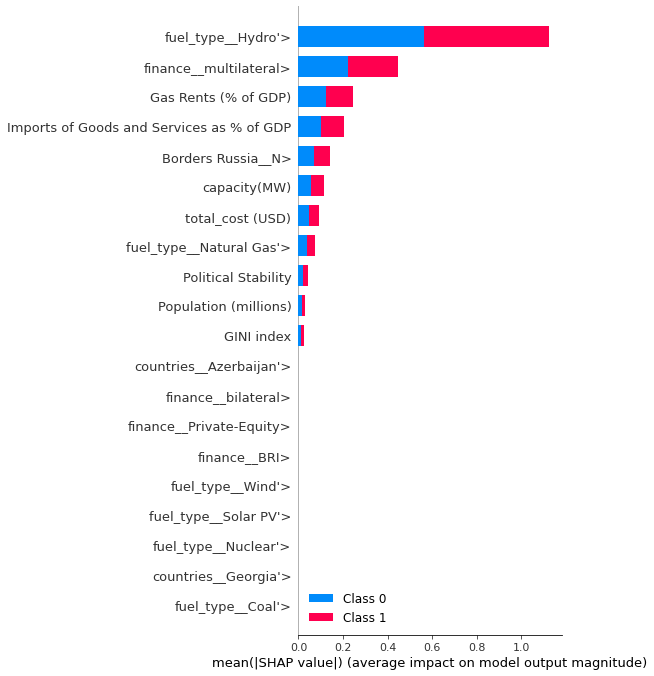

In [ ]:
X_importance = X_test

explainer = shap.TreeExplainer(lgb_model_1)
shap_values = explainer.shap_values(X_importance)

shap.summary_plot(shap_values, X_importance)

## Model 2: XGBoost Regression

### Training & Testing Model 2

[22:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.695515	validation_0-logloss:0.690039	validation_1-rmse:0.783242	validation_1-logloss:0.662165
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[20]	validation_0-rmse:0.626746	validation_0-logloss:0.494797	validation_1-rmse:0.665624	validation_1-logloss:0.275696
[40]	validation_0-rmse:0.622147	validation_0-logloss:0.474681	validation_1-rmse:0.593185	validation_1-logloss:-2.1829
[60]	validation_0-rmse:0.626028	validation_0-logloss:0.524942	validation_1-rmse:0.544974	validation_1-logloss:-4.41511
[80]	validation_0-rmse:0.634384	validation_0-logloss:4.4845	validation_1-rmse:0.506447	validation_1-logloss:-4.89049
[100]	validation_0-rmse:0.648862	validation_0-logloss:4.49713	validation_1-rmse:0.474588	validation_1-logloss:-5.9954

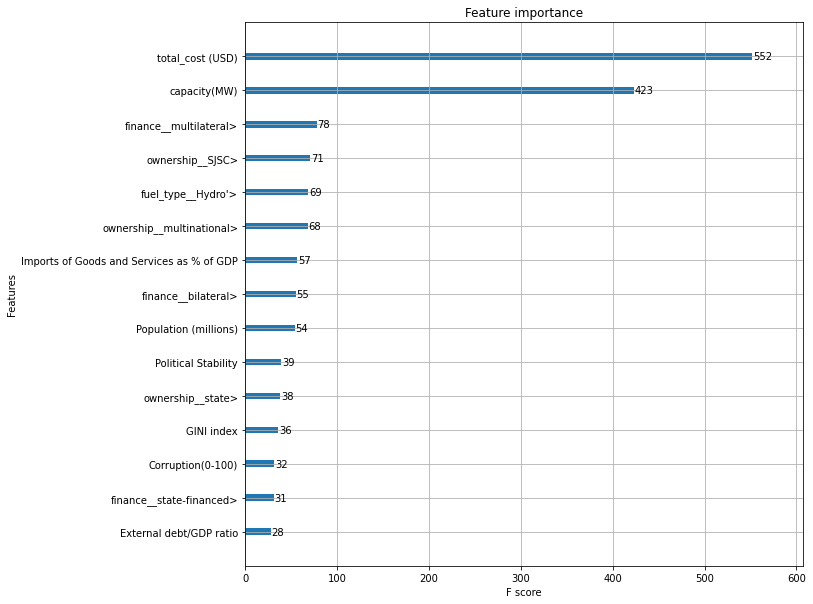

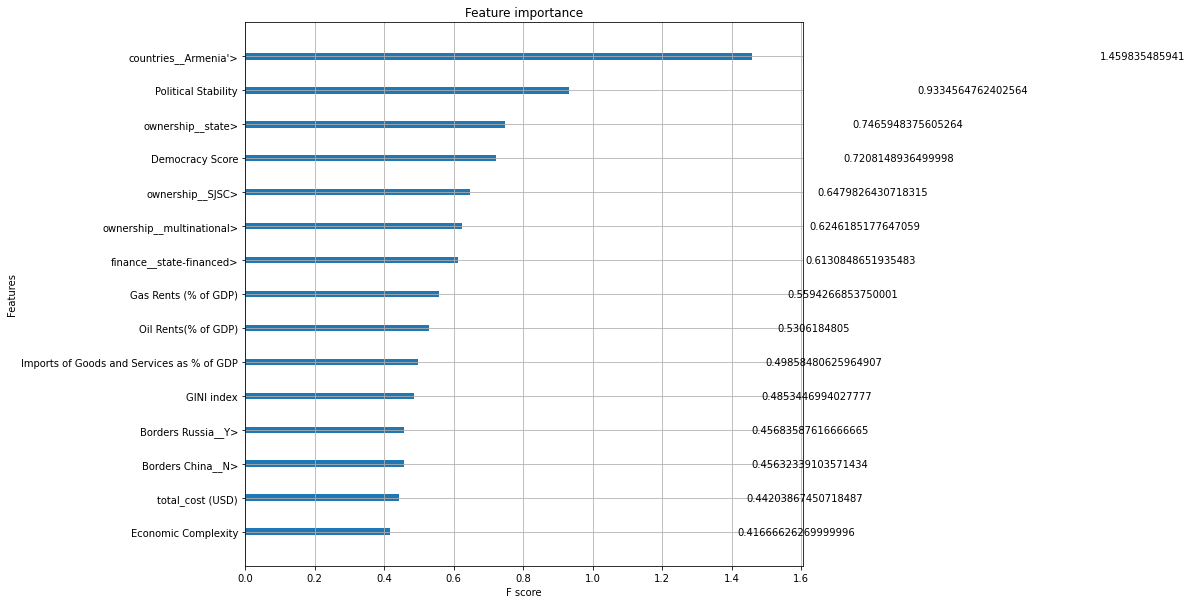

In [ ]:
from xgboost.sklearn import XGBRegressor
import xgboost
import re
from math import sqrt
from xgboost import plot_importance
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

data_ml.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data_ml.columns.values]


X = data_ml.drop('status_label', axis=1).fillna(0)
y = data_ml['status_label'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)


xgb_model_1 = XGBRegressor(max_depth=6,
                           n_estimators=300,
                           min_child_weight=7.5,
                           learning_rate=0.03,
                           nthread=8,
                           subsample=0.80,
                           colsample_bytree=0.80)

xgb_model_1.fit(
    X_train, y_train,
    eval_set = [(X_test, y_test),(X_train,y_train)],
    verbose = 20,
    eval_metric = ['rmse',"logloss"],
    early_stopping_rounds = 50)

print("Best Iteration: {}".format(xgb_model_1.best_iteration))

y_pred = xgb_model_1.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print ("rmse:", rmse)
print ("error rate: ", rmse/np.mean(y_test))

ax_1 = plot_importance(xgb_model_1, max_num_features = 15, importance_type = 'weight')
fig_1 = ax_1.figure
fig_1.set_size_inches(10,10)

ax_2 = plot_importance(xgb_model_1, max_num_features = 15, importance_type = 'gain')
fig_2 = ax_2.figure
fig_2.set_size_inches(10,10)


### SHAP values for Model 2
- Positive SHAP value means positive impact on prediction, leading the model to predict 1
- Negative SHAP value means negative impact, leading the model to predict 0
- Each point on the chart is one SHAP value for a prediction and feature. Red = higher value of a feature. Blue = lower value of a feature.


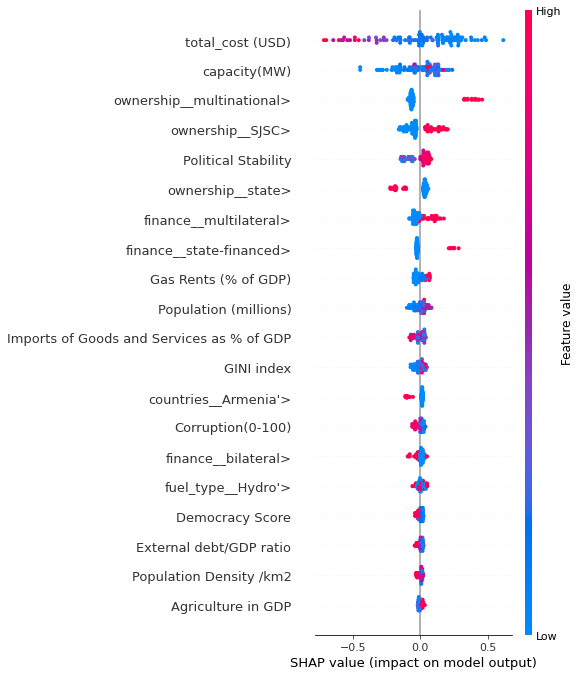

ValueError: ignored

In [ ]:
Xd = xgboost.DMatrix(X, label=y)
explainer = shap.TreeExplainer(xgb_model_1)
shap_values = explainer.shap_values(Xd)
shap.summary_plot(shap_values, X)